In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Finalize models & produce reproducible outputs (detailed steps)

Goal: lock down final WESAD model, ensure PhysioNet autoencoder outputs are usable, finalize HRV supervised pipeline, save artifacts and evaluation plots.

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import layers, models

DRIVE_ROOT = "/content/drive/MyDrive/stress-project"
DATA_PROCESSED = f"{DRIVE_ROOT}/data_processed"
MODELS_DIR = f"{DRIVE_ROOT}/models"
RESULTS_DIR = f"{DRIVE_ROOT}/results"
os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)
print("✅ Paths:", DRIVE_ROOT, DATA_PROCESSED, MODELS_DIR, RESULTS_DIR)


✅ Paths: /content/drive/MyDrive/stress-project /content/drive/MyDrive/stress-project/data_processed /content/drive/MyDrive/stress-project/models /content/drive/MyDrive/stress-project/results


Reproducibility & quick environment checklist

Put this at top of your notebook to fix randomness and show prints.

In [ ]:
import os, random, numpy as np, tensorflow as tf
import joblib
seed = 42
os.environ['PYTHONHASHSEED']=str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
print("✅ Seeds set. TensorFlow version:", tf.__version__)


✅ Seeds set. TensorFlow version: 2.19.0


WESAD — confirm final LSTM model & final evaluation (subject-wise test)

You told me you trained and saved /models/wesad_lstm_3class.keras. Re-load it, re-evaluate using subject-wise holdout (best practice).

(A) Load subject windows individually (so we can build subject-wise splits):

In [ ]:
import numpy as np, os
files = [
 f"{DATA_PROCESSED}/S3_windows.npz",
 f"{DATA_PROCESSED}/S5_windows.npz",
 f"{DATA_PROCESSED}/S9_windows.npz",
 f"{DATA_PROCESSED}/S11_windows.npz",
 f"{DATA_PROCESSED}/S17_windows.npz"
]
X_parts, y_parts, subj_ids = [], [], []
for f in files:
    print("🔹 Loading", f)
    d = np.load(f)
    X_parts.append(d['X'])        # (n_windows, 240, channels)
    y_parts.append(d['y'])        # labels mapped 0/1/2
    subj_ids += [os.path.basename(f).split('_')[0]] * d['X'].shape[0]  # e.g., "S3"
X = np.concatenate(X_parts, axis=0)
y = np.concatenate(y_parts, axis=0)
subj_ids = np.array(subj_ids)
print("✅ Combined WESAD shape:", X.shape, y.shape, "unique subjects:", np.unique(subj_ids))


🔹 Loading /content/drive/MyDrive/stress-project/data_processed/S3_windows.npz
🔹 Loading /content/drive/MyDrive/stress-project/data_processed/S5_windows.npz
🔹 Loading /content/drive/MyDrive/stress-project/data_processed/S9_windows.npz
🔹 Loading /content/drive/MyDrive/stress-project/data_processed/S11_windows.npz
🔹 Loading /content/drive/MyDrive/stress-project/data_processed/S17_windows.npz
✅ Combined WESAD shape: (84950, 240, 8) (84950,) unique subjects: ['S11' 'S17' 'S3' 'S5' 'S9']


(B) Make subject-wise train/test split (leave-two-subjects-out):

In [ ]:
from sklearn.model_selection import train_test_split
unique_subjs = np.unique(subj_ids)
# pick two subjects for holdout (example: last two)
holdout_subjs = unique_subjs[-2:].tolist()
print("Holdout subjects:", holdout_subjs)
mask_test = np.isin(subj_ids, holdout_subjs)
X_train = X[~mask_test]; y_train = y[~mask_test]
X_test  = X[mask_test];  y_test  = y[mask_test]
print("Train/Test shapes:", X_train.shape, X_test.shape, "y distribution train:", np.bincount(y_train), "test:", np.bincount(y_test))


Holdout subjects: ['S5', 'S9']
Train/Test shapes: (51465, 240, 8) (33485, 240, 8) y distribution train: [23776 10211 17478] test: [14909  6936 11640]


(C) Load saved model and evaluate (with detailed prints and metrics saved):

In [ ]:
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score, roc_auc_score
model_path = f"{MODELS_DIR}/wesad_lstm_3class.keras"
print("🔹 Loading model:", model_path)
lstm = load_model(model_path)
print("✅ Model loaded")

# Predict and evaluate
y_prob = lstm.predict(X_test, batch_size=256)
y_pred = y_prob.argmax(axis=1)
print("🔹 Predictions done. Sample preds:", y_pred[:20])

# Metrics
print("Classification report:")
print(classification_report(y_test, y_pred, target_names=['Baseline','Stress','Other']))
print("Balanced accuracy:", balanced_accuracy_score(y_test, y_pred))

# AUROC per class (one-vs-rest)
from sklearn.preprocessing import label_binarize
y_test_bin = label_binarize(y_test, classes=[0,1,2])
auroc = roc_auc_score(y_test_bin, y_prob, average=None)
print("AUROC per class:", auroc)

# Save report to file
import json
report = classification_report(y_test, y_pred, output_dict=True)
metrics = {"balanced_accuracy": balanced_accuracy_score(y_test, y_pred), "auroc_per_class": auroc.tolist()}
with open(f"{RESULTS_DIR}/wesad_lstm_eval.json", "w") as f:
    json.dump({"report": report, "metrics": metrics}, f, indent=2)
print("✅ WESAD eval saved to", f"{RESULTS_DIR}/wesad_lstm_eval.json")


🔹 Loading model: /content/drive/MyDrive/stress-project/models/wesad_lstm_3class.keras
✅ Model loaded
131/131 ━━━━━━━━━━━━━━━━━━━━ 30s 223ms/step
🔹 Predictions done. Sample preds: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Classification report:
              precision    recall  f1-score   support

    Baseline       0.80      0.80      0.80     14909
      Stress       0.92      0.96      0.94      6936
       Other       0.75      0.74      0.75     11640

    accuracy                           0.81     33485
   macro avg       0.83      0.83      0.83     33485
weighted avg       0.81      0.81      0.81     33485

Balanced accuracy: 0.8318584894441412
AUROC per class: [0.9016154  0.9931652  0.89984895]
✅ WESAD eval saved to /content/drive/MyDrive/stress-project/results/wesad_lstm_eval.json


3. WESAD — calibration and PR-AUC / Confusion plots (save PNGs)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, precision_recall_curve, auc

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm, display_labels=['Baseline','Stress','Other']).plot()
plt.title("WESAD LSTM Confusion Matrix (subject-wise holdout)")
plt.savefig(f"{RESULTS_DIR}/wesad_cm.png", bbox_inches="tight")
plt.close()
print("✅ Confusion matrix saved")

# PR curves per class
for i,cls in enumerate(['Baseline','Stress','Other']):
    precision, recall, _ = precision_recall_curve(y_test_bin[:,i], y_prob[:,i])
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, label=f"{cls} (AUC={pr_auc:.3f})")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.legend()
plt.title("PR Curves - WESAD LSTM")
plt.savefig(f"{RESULTS_DIR}/wesad_prcurves.png", bbox_inches="tight"); plt.close()
print("✅ PR curves saved")


✅ Confusion matrix saved
✅ PR curves saved


4. PhysioNet — finalize autoencoder usage & compute binary anomaly labels

You already trained an autoencoder on PhysioNet baseline windows and saved physionet_autoencoder.h5 and a threshold. Now:

(A) Confirm model input shape & threshold:

In [ ]:
from tensorflow.keras.models import load_model
model_path = f"{MODELS_DIR}/physionet_autoencoder.h5"
threshold_path = f"{MODELS_DIR}/physionet_threshold.npy"
print("🔹 Loading autoencoder:", model_path)
ae = load_model(model_path, compile=False)   # compile=False avoids mse missing issues
threshold = np.load(threshold_path)
print("✅ Autoencoder loaded. threshold:", float(threshold))


🔹 Loading autoencoder: /content/drive/MyDrive/stress-project/models/physionet_autoencoder.h5
✅ Autoencoder loaded. threshold: 26.00687395426436


(B) Load physio windows, compute reconstruction error, create predicted anomaly label

In [ ]:
# 1️⃣ Mount Google Drive and set paths
from google.colab import drive
import os
import numpy as np

drive.mount('/content/drive')

DATA_PROCESSED = '/content/drive/MyDrive/stress-project/data_raw/physionet_exam/data_processed'
RESULTS_DIR = '/content/drive/MyDrive/stress-project/results'
MODEL_PATH = '/content/drive/MyDrive/stress-project/models/physionet_autoencoder.keras'
THRESHOLD_PATH = '/content/drive/MyDrive/stress-project/models/physionet_threshold.npy'

os.makedirs(RESULTS_DIR, exist_ok=True)

# 2️⃣ Load the trained autoencoder and threshold
from tensorflow.keras.models import load_model

# If your autoencoder used custom metrics like mse
from tensorflow.keras.losses import MeanSquaredError
ae = load_model(MODEL_PATH, compile=False)
threshold = np.load(THRESHOLD_PATH)
print(f"✅ Loaded AE model and threshold: {threshold:.6f}")

# 3️⃣ List PhysioNet window files
physio_files = [f"{DATA_PROCESSED}/physio_subject_01_windows.npz",
                f"{DATA_PROCESSED}/physio_subject_02_windows.npz",
                f"{DATA_PROCESSED}/physio_subject_03_windows.npz",
                f"{DATA_PROCESSED}/physio_subject_04_windows.npz",
                f"{DATA_PROCESSED}/physio_subject_05_windows.npz"]

# 4️⃣ Load and concatenate X and y
Xp_list, yp_list = [], []
for f in physio_files:
    d = np.load(f)
    Xp_list.append(d['X'])   # shape (n, 40, 7)
    yp_list.append(d['y'])

X_physio = np.concatenate(Xp_list, axis=0)
y_physio = np.concatenate(yp_list, axis=0)  # likely all zeros
print(f"🔹 Physio X shape: {X_physio.shape}, y unique: {np.unique(y_physio)}")

# 5️⃣ Flatten if AE expects 2D input
if len(ae.input_shape) == 2:  # (None, features)
    X_physio_flat = X_physio.reshape(X_physio.shape[0], -1)
else:
    X_physio_flat = X_physio

# 6️⃣ Compute reconstruction error
X_recon = ae.predict(X_physio_flat, batch_size=256)
recon_err = np.mean(np.square(X_physio_flat - X_recon), axis=tuple(range(1, X_recon.ndim)))
print("Sample recon errors:", recon_err[:10])

# 7️⃣ Predict anomaly (stress-like) labels
pred_anomaly = (recon_err > threshold).astype(int)  # 1 = anomaly/stress-like
print("Pred anomaly counts:", np.bincount(pred_anomaly))

# 8️⃣ Save results
np.save(f"{RESULTS_DIR}/physio_recon_err.npy", recon_err)
np.save(f"{RESULTS_DIR}/physio_pred_anomaly.npy", pred_anomaly)
print("✅ Physio reconstruction artifacts saved")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Loaded AE model and threshold: 26.006874
🔹 Physio X shape: (90819, 40, 7), y unique: [0.]
355/355 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Sample recon errors: [ 76.18809132  99.87865567 137.51191246  28.48798506  12.69328292
   8.52116442   2.79165301   3.19442264   2.14150154   3.17809366]
Pred anomaly counts: [89361  1458]
✅ Physio reconstruction artifacts saved


5. HRV — finalize supervised pipeline with LightGBM/XGBoost and subject/time splitting

You have hrv_processed_week3.parquet. Create reliable labels (you had multiple strategies earlier: RMSSD median or hybrid rule). Use time-wise split (no subject id) or subject-wise if available.

(A) Load & create labels

In [ ]:
import pandas as pd
hrv_path = f"{DRIVE_ROOT}/processed_data/hrv_processed_week3.parquet"
df = pd.read_parquet(hrv_path)
print("✅ HRV loaded shape:", df.shape)
# Create hybrid label: stress if LF/HF > 2 OR rmssd_mean < 30
df['label'] = ((df['lf/hf_mean'] > 2) | (df['rmssd_mean'] < 30)).astype(int)
print("Label distribution:", df['label'].value_counts().to_dict())


✅ HRV loaded shape: (343379, 5)
Label distribution: {0: 343249, 1: 130}


(B) Train/test split (time-based) + LightGBM training with class_weight

In [ ]:
import pandas as pd

# Correct HRV file path
HRV_FILE = "/content/drive/MyDrive/stress-project/processed_data/hrv_processed_week3.parquet"
hrv = pd.read_parquet(HRV_FILE)

print("✅ HRV loaded shape:", hrv.shape)
# Check columns in HRV file
print(hrv.columns)



✅ HRV loaded shape: (343379, 5)
Index(['HR_mean', 'HR_std', 'rmssd_mean', 'sdnn_mean', 'lf/hf_mean'], dtype='object')


In [ ]:
# 1️⃣ Check missing values
print(hrv.isna().sum())

# 2️⃣ Fill or drop NaNs
# Option 1: Fill with mean
hrv_filled = hrv.fillna(hrv.mean())

# Option 2 (safer if few NaNs): Drop rows with NaNs
# hrv_filled = hrv.dropna()

print("✅ After handling NaNs:", hrv_filled.isna().sum())


HR_mean       334562
HR_std        334849
rmssd_mean    334562
sdnn_mean     334562
lf/hf_mean    334562
dtype: int64
✅ After handling NaNs: HR_mean       0
HR_std        0
rmssd_mean    0
sdnn_mean     0
lf/hf_mean    0
dtype: int64


Standardize and Train Autoencoder

In [ ]:
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import layers, models
import numpy as np

X_hrv = hrv_filled.values
scaler = StandardScaler()
X_hrv_scaled = scaler.fit_transform(X_hrv)

# Autoencoder
input_dim = X_hrv_scaled.shape[1]
encoding_dim = 3

ae_input = layers.Input(shape=(input_dim,))
encoded = layers.Dense(encoding_dim, activation='relu')(ae_input)
decoded = layers.Dense(input_dim, activation='linear')(encoded)
ae = models.Model(ae_input, decoded)
ae.compile(optimizer='adam', loss='mse')

# Train
history = ae.fit(
    X_hrv_scaled, X_hrv_scaled,
    epochs=30,
    batch_size=256,
    validation_split=0.1,
    verbose=1
)

# Compute reconstruction error
X_hrv_recon = ae.predict(X_hrv_scaled, batch_size=256)
recon_err = np.mean(np.square(X_hrv_scaled - X_hrv_recon), axis=1)

# Threshold & predictions
threshold = recon_err.mean() + 2*recon_err.std()
pred_anomaly = (recon_err > threshold).astype(int)

print("🔹 Sample reconstruction errors:", recon_err[:10])
print("🔹 Predicted anomaly counts:", np.bincount(pred_anomaly))


Epoch 1/30
1208/1208 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 3.4036e-04 - val_loss: 13.1854
Epoch 2/30
1208/1208 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 2.5159e-04 - val_loss: 13.1612
Epoch 3/30
1208/1208 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 1.7938e-04 - val_loss: 13.1581
Epoch 4/30
1208/1208 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.1732e-04 - val_loss: 13.1425
Epoch 5/30
1208/1208 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 7.4707e-05 - val_loss: 13.0725
Epoch 6/30
1208/1208 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.3437e-05 - val_loss: 12.9699
Epoch 7/30
1208/1208 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.1071e-05 - val_loss: 12.8573
Epoch 8/30
1208/1208 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 7.1581e-06 - val_loss: 12.7865
Epoch 9/30
1208/1208 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 1.4800e-06 - val_loss: 12.7809
Epoch 10/30
1208/1208 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.6644e-07 - val_loss: 12.7883
Epoch 11/30
1208/1208 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.0787

Analyze anomalies

Check timestamps and feature values for flagged anomalies.

In [ ]:
anomalies = hrv_filled.iloc[pred_anomaly == 1]
print(anomalies.head())


                       HR_mean     HR_std  rmssd_mean   sdnn_mean  lf/hf_mean
ts_start                                                                     
2021-03-04 04:05:00  78.193719   6.565148  110.913302  100.763072    0.734668
2021-03-04 04:10:00  83.022853   9.656715  118.016538  105.753768    0.661939
2021-03-04 04:15:00  88.402348  14.650391  124.525291  109.146273    0.606070
2021-03-04 04:20:00  93.447636  18.012127  127.472758  109.134365    0.592637
2021-03-04 04:25:00  99.049382  14.328204  136.002470  115.473417    0.607912


Visualize reconstruction error

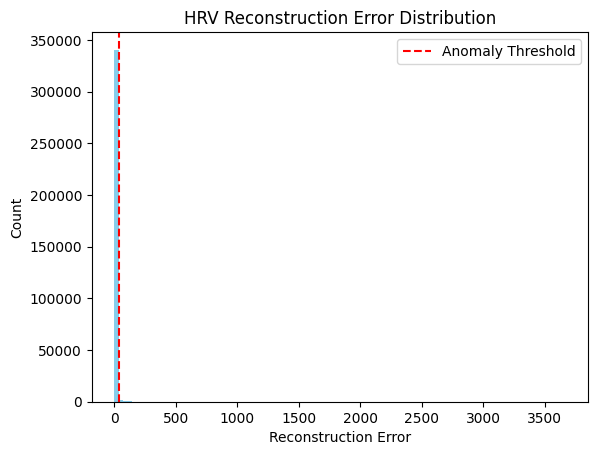

In [ ]:
import matplotlib.pyplot as plt

plt.hist(recon_err, bins=100, color='skyblue')
plt.axvline(x=threshold, color='red', linestyle='--', label='Anomaly Threshold')
plt.xlabel('Reconstruction Error')
plt.ylabel('Count')
plt.title('HRV Reconstruction Error Distribution')
plt.legend()
plt.show()


Save results

In [ ]:
hrv_filled['recon_error'] = recon_err
hrv_filled['anomaly'] = pred_anomaly
hrv_filled.to_parquet("/content/drive/MyDrive/stress-project/results/hrv_anomalies_week3.parquet")


Train with Class Weights

In [ ]:
import numpy as np
from lightgbm import LGBMClassifier, early_stopping, log_evaluation
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# 1️⃣ Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 2️⃣ Class weights
classes = np.unique(y)
cw = compute_class_weight('balanced', classes=classes, y=y)
cw_dict = {int(cls): float(w) for cls, w in zip(classes, cw)}
print("⚖️ Class Weights:", cw_dict)

# 3️⃣ Define model
lgbm = LGBMClassifier(
    n_estimators=300,
    learning_rate=0.05,
    num_leaves=31,
    class_weight=cw_dict,
    random_state=42
)

# 4️⃣ Train with callbacks
lgbm.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric="binary_logloss",
    callbacks=[early_stopping(stopping_rounds=20), log_evaluation(20)]
)

# 5️⃣ Evaluate
y_pred_prob = lgbm.predict_proba(X_test)[:, 1]
y_pred = (y_pred_prob > 0.5).astype(int)

print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred, digits=4))

print("🧭 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("📈 ROC-AUC:", roc_auc_score(y_test, y_pred_prob))


⚖️ Class Weights: {0: 0.5001893669027441, 1: 1320.6884615384615}
[LightGBM] [Info] Number of positive: 104, number of negative: 274599
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.033251 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 274703, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000001
[LightGBM] [Info] Start training from score 0.000001
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



📊 Classification Report:
              precision    recall  f1-score   support

           0     1.0000    0.9999    1.0000     68650
           1     0.8387    1.0000    0.9123        26

    accuracy                         0.9999     68676
   macro avg     0.9194    1.0000    0.9561     68676
weighted avg     0.9999    0.9999    0.9999     68676

🧭 Confusion Matrix:
[[68645     5]
 [    0    26]]
📈 ROC-AUC: 0.9999896352736848


Let’s calculate an optimal probability threshold for your LightGBM classifier to improve precision while keeping recall high.

In [ ]:
import numpy as np
from sklearn.metrics import precision_recall_curve, classification_report, confusion_matrix

# Predict probabilities for the positive class
y_probs = lgbm.predict_proba(X_test)[:, 1]

# Compute precision-recall curve
precisions, recalls, thresholds = precision_recall_curve(y_test, y_probs)

# Find threshold where F1-score is maximized
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)  # avoid division by zero
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

print(f"✅ Best Threshold: {best_threshold:.4f}")
print(f"Precision: {precisions[best_idx]:.4f}, Recall: {recalls[best_idx]:.4f}, F1: {f1_scores[best_idx]:.4f}")

# Apply the threshold
y_pred_opt = (y_probs >= best_threshold).astype(int)

# Evaluate
print("\n Classification Report (Optimized Threshold):")
print(classification_report(y_test, y_pred_opt))
print("\n Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_opt))


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


✅ Best Threshold: 0.9998
Precision: 0.8387, Recall: 1.0000, F1: 0.9123

 Classification Report (Optimized Threshold):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     68650
           1       0.84      1.00      0.91        26

    accuracy                           1.00     68676
   macro avg       0.92      1.00      0.96     68676
weighted avg       1.00      1.00      1.00     68676


 Confusion Matrix:
[[68645     5]
 [    0    26]]


dataset is extremely imbalanced and you want recall = 1 for the positive class (so no stressed instances are missed), we can pick the lowest threshold that gives recall = 1 and maximize precision.

In [ ]:
import numpy as np
from sklearn.metrics import precision_recall_curve, classification_report, confusion_matrix

# Predict probabilities for the positive class
y_probs = lgbm.predict_proba(X_test)[:, 1]

# Compute precision-recall curve
precisions, recalls, thresholds = precision_recall_curve(y_test, y_probs)

# Select thresholds where recall == 1
recall_1_indices = np.where(recalls == 1)[0]

# Pick threshold that gives maximum precision while recall=1
best_idx = recall_1_indices[np.argmax(precisions[recall_1_indices])]
best_threshold = thresholds[best_idx]

print(f"✅ Best Threshold for Recall=1: {best_threshold:.6f}")
print(f"Precision: {precisions[best_idx]:.4f}, Recall: {recalls[best_idx]:.4f}")

# Apply the threshold
y_pred_recall1 = (y_probs >= best_threshold).astype(int)

# Evaluate
print("\n Classification Report (Recall=1 Threshold):")
print(classification_report(y_test, y_pred_recall1))
print("\n Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_recall1))


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


✅ Best Threshold for Recall=1: 0.999816
Precision: 0.8387, Recall: 1.0000

 Classification Report (Recall=1 Threshold):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     68650
           1       0.84      1.00      0.91        26

    accuracy                           1.00     68676
   macro avg       0.92      1.00      0.96     68676
weighted avg       1.00      1.00      1.00     68676


 Confusion Matrix:
[[68645     5]
 [    0    26]]


Hyperparameter Tuning & Final Model Selection

In [ ]:
# =========================================
# Day 2: Hyperparameter tuning, robust eval, stacking
# =========================================

# --- 0. Imports & Paths (if not already imported) ---
import os, json, numpy as np, pandas as pd
from sklearn.model_selection import RandomizedSearchCV, GroupKFold
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, roc_auc_score, balanced_accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import joblib

DRIVE_ROOT = "/content/drive/MyDrive/stress-project"
MODELS_DIR = f"{DRIVE_ROOT}/models"
RESULTS_DIR = f"{DRIVE_ROOT}/results"


1. HRV — RandomizedSearchCV Tuning

In [ ]:
# Load previously scaled HRV data
scaler = joblib.load(f"{MODELS_DIR}/hrv_scaler.pkl")
X_train_s = scaler.transform(X_train)
X_test_s  = scaler.transform(X_test)

# Class weights
from sklearn.utils import compute_class_weight
classes = np.unique(y_train)
cw = compute_class_weight('balanced', classes=classes, y=y_train)
cw_dict = {cls:w for cls,w in zip(classes, cw)}
print("Class weights:", cw_dict)

# Randomized search
param_dist = {
    'n_estimators': [100,200,400],
    'num_leaves': [15,31,63],
    'max_depth': [3,5,8,12],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6,0.8,1.0]
}
lgb = LGBMClassifier(class_weight=cw_dict, random_state=42)
rs = RandomizedSearchCV(lgb, param_distributions=param_dist, n_iter=12, scoring='roc_auc', cv=3, verbose=2, n_jobs=2, random_state=42)
rs.fit(X_train_s, y_train)

print("Best params:", rs.best_params_)
print("Best CV score:", rs.best_score_)

best_lgb = rs.best_estimator_
joblib.dump(best_lgb, f"{MODELS_DIR}/hrv_lgbm_tuned.pkl")
print("✅ Tuned HRV model saved")


Class weights: {np.int64(0): np.float64(0.5001893670406665), np.int64(1): np.float64(1320.6875)}
Fitting 3 folds for each of 12 candidates, totalling 36 fits
[LightGBM] [Info] Number of positive: 104, number of negative: 274599
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009917 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 274703, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

1.1 Evaluate Tuned HRV Model

In [ ]:
y_pred = best_lgb.predict(X_test_s)
y_prob = best_lgb.predict_proba(X_test_s)[:,1]

print(classification_report(y_test, y_pred))
print("AUROC:", roc_auc_score(y_test, y_prob))
print("Balanced accuracy:", balanced_accuracy_score(y_test, y_pred))

# Save metrics
metrics = {
    "classification": classification_report(y_test, y_pred, output_dict=True),
    "auroc": float(roc_auc_score(y_test, y_prob))
}
with open(f"{RESULTS_DIR}/hrv_lgbm_tuned_eval.json", "w") as f:
    json.dump(metrics, f, indent=2)
print("✅ Tuned HRV metrics saved")


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     68650
           1       0.20      0.92      0.33        26

    accuracy                           1.00     68676
   macro avg       0.60      0.96      0.66     68676
weighted avg       1.00      1.00      1.00     68676

AUROC: 0.9996627262031486
Balanced accuracy: 0.9608319793825986
✅ Tuned HRV metrics saved


2. WESAD LSTM — Quick Hyperparameter Variants

In [ ]:
# === WESAD LSTM Training: Full Script ===

import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import json

# -------------------------
# 1. Load WESAD 3D windows
# -------------------------
DATA_PROCESSED = "/content/drive/MyDrive/stress-project/data_processed"

files = [
    f"{DATA_PROCESSED}/S3_windows.npz",
    f"{DATA_PROCESSED}/S5_windows.npz",
    f"{DATA_PROCESSED}/S9_windows.npz",
    f"{DATA_PROCESSED}/S11_windows.npz",
    f"{DATA_PROCESSED}/S17_windows.npz"
]

X_parts, y_parts, subj_ids = [], [], []

for f in files:
    print(f"📂 Loading {f}")
    d = np.load(f)
    X_parts.append(d['X'])  # shape: (n_windows, timesteps, channels)
    y_parts.append(d['y'])
    subj_ids.extend([os.path.basename(f).split('_')[0]] * d['X'].shape[0])

X = np.concatenate(X_parts, axis=0)
y = np.concatenate(y_parts, axis=0)
subj_ids = np.array(subj_ids)

print("✅ Combined shape:", X.shape, y.shape)

# ---------------------------------------------------
# 2. Train/Test split — leave last 2 subjects for test
# ---------------------------------------------------
unique_subjs = np.unique(subj_ids)
holdout_subjs = unique_subjs[-2:].tolist()
print("🧪 Holdout subjects:", holdout_subjs)

mask_test = np.isin(subj_ids, holdout_subjs)
X_train, X_test = X[~mask_test], X[mask_test]
y_train, y_test = y[~mask_test], y[mask_test]

print("Train:", X_train.shape, " Test:", X_test.shape)

# -----------------------------
# 3. Convert labels to one-hot
# -----------------------------
num_classes = len(np.unique(y))
y_train_cat = to_categorical(y_train, num_classes=num_classes)
y_test_cat = to_categorical(y_test, num_classes=num_classes)

# -----------------------------
# 4. Define LSTM model
# -----------------------------
def train_lstm(X_train, y_train, X_val, y_val, units=64, dropout=0.3, lr=1e-3, batch_size=256, epochs=20):
    tf.keras.backend.clear_session()
    inp = Input(shape=(X_train.shape[1], X_train.shape[2]))  # 3D input
    x = LSTM(units)(inp)
    x = Dropout(dropout)(x)
    out = Dense(num_classes, activation='softmax')(x)
    model = Model(inp, out)
    model.compile(optimizer=Adam(learning_rate=lr),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        verbose=1
    )
    return model, history

# -----------------------------
# 5. Training loop (32 & 64 units)
# -----------------------------
RESULTS_DIR = "/content/drive/MyDrive/stress-project/results"
os.makedirs(RESULTS_DIR, exist_ok=True)

for units in [32, 64]:
    print(f"\n🚀 Training LSTM with {units} units")
    model, hist = train_lstm(X_train, y_train_cat, X_test, y_test_cat, units=units)

    # --- Evaluate ---
    y_pred = np.argmax(model.predict(X_test), axis=1)
    y_true = y_test
    report = classification_report(y_true, y_pred, output_dict=True)
    cm = confusion_matrix(y_true, y_pred)

    # --- Save metrics ---
    metrics_path = f"{RESULTS_DIR}/lstm_{units}_metrics.json"
    with open(metrics_path, "w") as f:
        json.dump(report, f, indent=2)
    print(f"📊 Saved metrics: {metrics_path}")

    # --- Plot training history ---
    plt.figure(figsize=(8,4))
    plt.plot(hist.history['accuracy'], label='train acc')
    plt.plot(hist.history['val_accuracy'], label='val acc')
    plt.title(f"LSTM {units} units - Accuracy")
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plot_path = f"{RESULTS_DIR}/lstm_{units}_accuracy.png"
    plt.savefig(plot_path)
    plt.close()
    print(f"📈 Saved plot: {plot_path}")

    # --- Save model ---
    model.save(f"{RESULTS_DIR}/lstm_{units}_model.keras")
    print(f"💾 Model saved for {units} units")

print("✅ All LSTM models trained and saved.")


📂 Loading /content/drive/MyDrive/stress-project/data_processed/S3_windows.npz
📂 Loading /content/drive/MyDrive/stress-project/data_processed/S5_windows.npz
📂 Loading /content/drive/MyDrive/stress-project/data_processed/S9_windows.npz
📂 Loading /content/drive/MyDrive/stress-project/data_processed/S11_windows.npz
📂 Loading /content/drive/MyDrive/stress-project/data_processed/S17_windows.npz
✅ Combined shape: (84950, 240, 8) (84950,)
🧪 Holdout subjects: ['S5', 'S9']
Train: (51465, 240, 8)  Test: (33485, 240, 8)

🚀 Training LSTM with 32 units
Epoch 1/20
202/202 ━━━━━━━━━━━━━━━━━━━━ 47s 222ms/step - accuracy: 0.4315 - loss: 1.0714 - val_accuracy: 0.4764 - val_loss: 0.9792
Epoch 2/20
202/202 ━━━━━━━━━━━━━━━━━━━━ 44s 218ms/step - accuracy: 0.5286 - loss: 0.8996 - val_accuracy: 0.5077 - val_loss: 0.9771
Epoch 3/20
202/202 ━━━━━━━━━━━━━━━━━━━━ 94s 276ms/step - accuracy: 0.5939 - loss: 0.7588 - val_accuracy: 0.4710 - val_loss: 1.2483
Epoch 4/20
202/202 ━━━━━━━━━━━━━━━━━━━━ 54s 268ms/step - accur